In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots
plt.style.use(["science", "notebook", "grid", "dark_background"])

In [4]:
class SigMoidOptimiser:
    def __init__(self, x_pts, true_w, true_b) -> None:
        self.x_pts = x_pts
        self.true_w = true_w
        self.true_b = true_b
        self.w, self.b = np.random.uniform(-6, 6,  size=2)
        self.ytrue = self.calc_sigmoid(self.x_pts, self.true_w, self.true_b)
        self.yhat = self.calc_sigmoid(self.x_pts, self.w, self.b)
    
    @staticmethod
    def calc_sigmoid(x, w, b):
        return 1.0 / (1.0 + np.exp(-(w * x - b)))

    def loss(self):
        return 0.5 * np.sum((self.yhat - self.ytrue) ** 2)
    
    
    def calc_gradient(self):
        dw = np.sum((self.yhat - self.ytrue) * self.yhat * (1 - self.yhat) * self.x_pts)
        db = np.sum((self.yhat - self.ytrue) * self.yhat * (1 - self.yhat))
        return dw, db
    
    @staticmethod
    def calculate_lookahead_gradient(x, ytrue, w, b, v_w, v_b, lr, gamma):
        w_lookahead = w - gamma * v_w
        b_lookahead = b - gamma * v_b
        yhat = SigMoidOptimiser.calc_sigmoid(x, w_lookahead, b_lookahead)
        dw_lookahead = np.sum((yhat - ytrue) * yhat * (1 - yhat) * x)
        db_lookahead = np.sum((yhat - ytrue) * yhat * (1 - yhat))
        return dw_lookahead, db_lookahead

    def do_vanilla_gradient_descent(self, lr=0.02, epochs=100, starting_point = (-4, -4)):
        """Does vanilla gradient descent"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        for idx in range(epochs):
            dw, db = self.calc_gradient()
            self.w -= lr * dw # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= lr * db # Update the b value
            bs[idx] = self.b
            self.yhat = self.calc_sigmoid(self.x_pts, self.w, self.b)
            self.losses[idx] = self.loss() # Append the new loss value
        return self.losses, ws, bs
    
    def do_momentum_gradient_descent(self, lr = 0.02, epochs = 100, gamma = 0.9, starting_point = (-4, -4)):
        """Does momentum gradient descent"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0. # Initialising the velocity
        
        for idx in range(epochs):
            dw, db = self.calc_gradient()

            # Look at the history of the gradients
            v_w = gamma * v_w + lr * dw
            v_b = gamma * b_w + lr * db

            self.w -= v_w # Update the w value
            ws[idx] = self.w # Append the new w value
            self.b -= v_b # Update the b value
            bs[idx] = self.b # Append the new b value

            # Calculate the new predictions and loss
            self.yhat = self.calc_sigmoid(self.x_pts, self.w, self.b)
            self.losses[idx] = self.loss()
        return self.losses, ws, bs
    
    def do_nesterov_accelerated_gradient_descent(self, lr = 0.02, epochs = 100, gamma = 0.9, starting_point = (-4, -4)):
        """Does nested momentum gradient descent"""
        self.w, self.b = starting_point
        self.losses = np.zeros(epochs)
        ws, bs = np.zeros(epochs), np.zeros(epochs)
        v_w, b_w = 0., 0.

        for idx in range(epochs):
            dw_lookahead, db_lookahead = self.calculate_lookahead_gradient(self.x_pts, self.ytrue, self.w, self.b, v_w, b_w, lr, gamma)

            v_w = gamma * v_w + lr * dw_lookahead
            v_b = gamma * b_w + lr * db_lookahead

            self.w -= v_w
            ws[idx] = self.w

            self.b -= v_b
            bs[idx] = self.b

            self.yhat = self.calc_sigmoid(self.x_pts, self.w, self.b)
            self.losses[idx] = self.loss()

        return self.losses, ws, bs

    def trace_path(self, x_pts, y_pts, color, label, fig, ax):
        ax.plot(x_pts, y_pts, "o--", color=color, label = label, linewidth = 0.5, markersize = 1)
        ax.scatter(x_pts[0], y_pts[0], color = color, s = 200, marker = "p")
        ax.scatter(x_pts[-1], y_pts[-1], color = color, s = 200, marker = "x")
        ax.legend()

    def plot_loss_landscape(self, fig, ax):
        w_values = np.linspace(-6, 6, 200)  # Example range for w
        b_values = np.linspace(-6, 6, 200)  # Example range for b
        W, B = np.meshgrid(w_values, b_values)

        # Calculate predictions and MSE loss for each w, b pair
        loss_matrix = np.zeros(W.shape)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j]
                b = B[i, j]
                y_pred = self.calc_sigmoid(self.x_pts, w, b)  # Calculate predictions for this w, b
                mse_loss = 0.5 * np.sum((y_pred - self.ytrue) ** 2)  # Calculate MSE loss
                loss_matrix[i, j] = mse_loss

        cax = ax.contourf(W, B, loss_matrix, levels=20, cmap="coolwarm")
        ax.set_xlabel(r"w $\rightarrow$", fontsize = 15, fontweight = "bold")
        ax.set_ylabel(r"b $\rightarrow$", fontsize = 15, fontweight = "bold")
        ax.set_title("Loss landscape", fontsize = 20, fontweight = "bold")
        fig.colorbar(cax, ax=ax, orientation="vertical", label = "Loss")
        return loss_matrix, w_values, b_values

In [5]:
x_pts = np.linspace(-4, 4, 5)
true_w, true_b = 0.5, -2

sig = SigMoidOptimiser(x_pts, true_w, true_b)

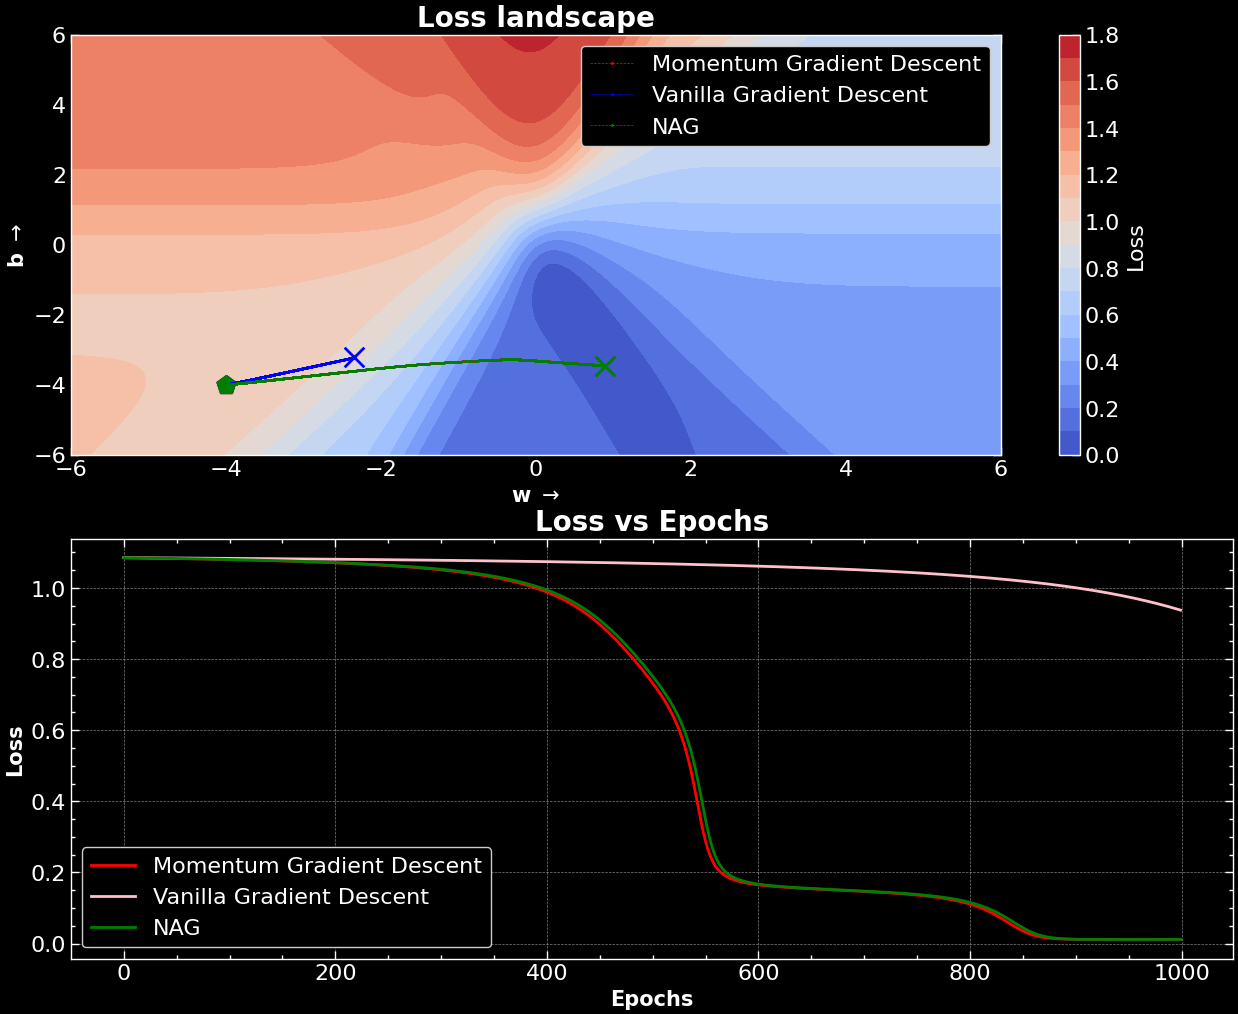

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
ax1, ax2 = ax.ravel()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-6, 6)

loss_matrix, w_vals, b_vals = sig.plot_loss_landscape(fig, ax1)
losses_VGD, ws_VGD, bs_VGD = sig.do_vanilla_gradient_descent(lr = 0.02, epochs = 1000)
losses_MGD, ws_MGD, bs_MGD = sig.do_momentum_gradient_descent(lr = 0.02, epochs = 1000, gamma = 0.5)
losses_NMGD, ws_NMGD, bs_NMGD = sig.do_nesterov_accelerated_gradient_descent(lr = 0.02, epochs = 1000, gamma = 0.5)

sig.trace_path(ws_MGD, bs_MGD, "red", "Momentum Gradient Descent", fig, ax1)
sig.trace_path(ws_VGD, bs_VGD, "blue", "Vanilla Gradient Descent", fig, ax1)
sig.trace_path(ws_NMGD, bs_NMGD, "green", "NAG", fig, ax1)


ax2.plot(losses_MGD, label = "Momentum Gradient Descent", color = "red")
ax2.plot(losses_VGD, label = "Vanilla Gradient Descent", color = "pink")
ax2.plot(losses_NMGD, label = "NAG", color = "green")
ax2.set_xlabel("Epochs", fontsize = 15, fontweight = "bold")
ax2.set_ylabel("Loss", fontsize = 15, fontweight = "bold")
ax2.set_title("Loss vs Epochs", fontsize = 20, fontweight = "bold")
ax2.legend()

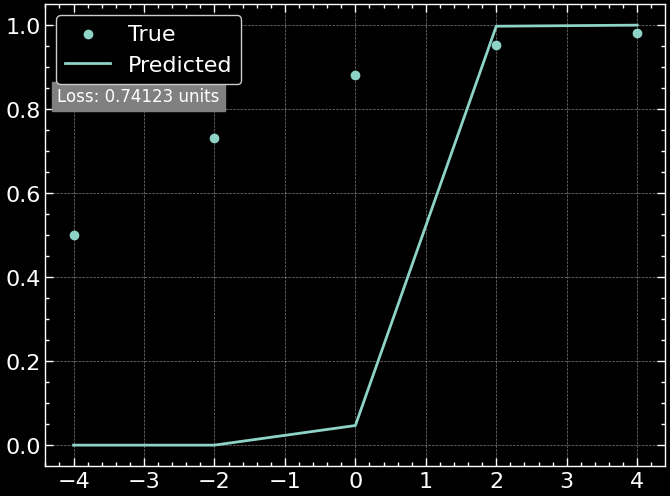

In [170]:
fig, ax = plt.subplots()
ax.scatter(x_pts, sig.ytrue, label="True")
ax.plot(x_pts, sig.yhat, label="Predicted")
ax.text(0.15, 0.8, f"Loss: {sig.loss():.5f} units", fontsize=12, ha="center", va="center", backgroundcolor="grey", 
        transform = ax.transAxes)
ax.legend()